In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import random
import re
import requests

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import GlorotUniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


# **Point 1 - MODEL.**

### **"which model do you identify most appropriate for this question and why"**


In my answer I reasoned about the problem and came to the conclusion that: if we want only to predict the **review type** (good or bad), where we had just one input, a classic model, built with the Sequential() function from Keras, would be fine. BUT, if we, instead, wanted to take the more complete, "correct" (and complex) route, where we intended to classify both the review and the score, it would be a case of **multi-output model**, with two outputs. Similarly, when we have to choose which input to use, we may just take one single input, making the model more simplified, or decide to have a more complete (and complex) model, which would use a multi-input structure. In such case, we would have a multi-input and multi-output model, which would necessitate that we not use the sequential() model from Keras, but rather the functional API.

My exam says: "we will process the different types of inputs separately, then use concatenate(), process, and then produce the two different outputs." As I said, the exact kind of merge we're choosing is usually discovered empirically. Nonetheless, we may infer that, since we are going to have heterogeneous input types (text features from LSTM and categorical features from Dense layers) with different dimensionalities, we may start with concatenation, since it is able to preserve all information from both branches, allowing the subsequent layers to learn optimal feature interactions.

Also, I wrote: "I would choose this type of model also because yes, we may just use the text of reviews to predict the rating. It is probably the single most important feature. Nonetheless, I find it relevant to add also the other features, such as review_date, properly modified into categories like months or seasons, maybe the number of reviews, the nationality, etc. Hotel-address could actually be interesting if we could get the geospatial data and measure the distances from tourist attractions – but I would leave this behind for this specific task."

So, I understood that we could use a simpler model, but went for the complex route. Here I already delineated input choices, model structure, and output, where I also already delineated the mathematical functions for outputs and activation and loss functions we would use: "If we want to predict not only the review type, which would be just a binary classification problem (good or bad), for which I would expect a single neuron with a sigmoid (1/1+e^-x) activation function that tells me whether it is good or bad, we may have another output, where we may instead want to predict the review_score, a float number, for which we may instead expect to need a regression function, no activation function, mean squared error as a loss. In this case we would have these two outputs. Also, as input, we do have multiple inputs, of different types: It is pretty clear that we will need a multi-input, multi-output (two) model. In this case, we clearly cannot use the simple sequential() model from Keras, but we rather will have to use the functional API to build a personalized model. We will process the different types of inputs separately, then use concatenate, process, and then produce the two different outputs.

For correctly implementing it, the first step is
### **DATA LOADING**

In [ ]:

# Download the data file
url = "http://my_professor_name/MLDNN/input_data.pkl"
response = requests.get(url)
with open('input_data.pkl', 'wb') as f:
    f.write(response.content)

# Load the data
data = pd.read_pickle('input_data.pkl')
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())




Data shape: (13772, 10)
Columns: ['Hotel_Address', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Hotel_number_reviews', 'Reviewer_number_reviews', 'Review_Score', 'Review', 'Review_Type']

First few rows:
                                           Hotel_Address Review_Date  \
88526  Scarsdale Scarsdale Place Kensington Kensingto...    5/2/2017   
42019  53 53 59 Kilburn High Road Maida Vale London C...    8/4/2016   
80574  Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain  11/17/2016   
27131  3 3 Place du G n ral Koenig 17th arr 75017 Par...    2/4/2016   
63857  Epping Epping Forest 30 Oak Hill London IG8 9N...   7/27/2016   

       Average_Score                              Hotel_Name  \
88526            8.1  Copthorne Tara Hotel London Kensington   
42019            7.1  BEST WESTERN Maitrise Hotel Maida Vale   
80574            8.6                 Catalonia Ramblas 4 Sup   
27131            7.1              Hyatt Regency Paris Etoile   
63857            

# **POINT 2a: INPUT DATA PREPROCESSING**


## **TEXT PREPROCESSING**

We do have raw text that needs to be preprocessed. Since the maximum length of words is 400, dimensionality reduction is not needed. I am preprocessing the text with the same exact passages I defined in the exam, specifically:

-	Split into tokens by whitespace – or we will remove special characters such as, as we saw in laboratories, “—” in the old texts with space
-	Remove punctuations
-   Convert to lowercase for consistency
-	“pad” the sequences to make them the same length. ( this will happen later in the code, where I am transforming for the input layer, as neural networks need fixed input size and we cannot feed variable-length sequences directly to Embedding/LSTM layers. )
-	Removing stopwords, but not too many since we are dealing with sentiment analysis and some could actually be useful, such as negations (not) or adjectives such as "very" etc


After having defined the preprocessing function, I will apply it to the column, and remove the original one , to not get confused later.


In [ ]:

def get_words(text):
    text = text.replace('--', ' ')
    text = text.replace('—', ' ')

    # split into tokens by white space
    words = text.split()

    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]

    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    # make lower case
    words = [word.lower() for word in words]

    # Remove stopwords - minimal list for sentiment analysis
    minimal_stopwords = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
    words = [word for word in words if word not in minimal_stopwords]

    return words



data['Review_Processed'] = data['Review'].apply(lambda x: ' '.join(get_words(x)))



In [ ]:
data['Review_Processed']

,Review_Processed
88526,expensive room rate that didn t include parkin...
42019,bedroom basement no windows very small room ne...
80574,room ready makeover location
27131,firstly lady check desk was quite unfriendly s...
63857,not being able park my vehicle due staff filli...
...,...
11403,cleanliness room temperature location facilities
18169,cost parking location
15180,staff was very helpful
24929,tout home away from home


In [ ]:
data = data.drop(columns = 'Review')

## **DATE PREPROCESSING**



I start by inspecting the column

In [ ]:
data['Review_Date']

,Review_Date
88526,5/2/2017
42019,8/4/2016
80574,11/17/2016
27131,2/4/2016
63857,7/27/2016
...,...
11403,3/9/2016
18169,9/1/2015
15180,9/4/2016
24929,10/6/2015


the dates are in M/D/YYYY format (like 5/2/2017, 8/4/2016)


As I stated in the exam, I need to preprocess DATE values by transforming them into categorical data.
As I stated in the exam, I have two main options: 
- (1) one-hot encode all 12 months, or 
- (2) group into fewer categories like seasons.

I chose the SEASONS approach (4 categories instead of 12) because:
- Reduces dimensionality while preserving meaningful patterns
- Hotel reviews likely have seasonal trends (summer vacations, winter holidays)


We saw that the date format is MM/DD/YYYY, so, as I stated in the exam, I use regex to extract the first 1-2 digits (month).
Following my exam reasoning about "2 digits + 2 + 2", I extract the month portion using regex pattern r'^(\d{1,2})/' to capture 1 or 2 digits before the first slash.

I then convert months to seasons and apply one-hot encoding, which creates binary features, suitable for neural networks (as opposed to keeping integers, which could imply ordinality).

I finally remove the original column in this dataframe copy to not get confused when selecting columns when building the model for training.


In [ ]:

def preprocess_dates(review_dates):
    # Extract month using regex
    months = review_dates.str.extract(r'^(\d{1,2})/', expand=False).astype(int)

    # Convert to seasons
    def month_to_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:  # [9, 10, 11]
            return 'Fall'

    seasons = months.map(month_to_season)

    # One-hot encode seasons
    season_dummies = pd.get_dummies(seasons, prefix='season')

    return season_dummies


# Step 1: Apply function to the Review_Date column
season_encoded = preprocess_dates(data['Review_Date'])

print("Date preprocessing complete!")
print(f"Created {len(season_encoded.columns)} season columns: {season_encoded.columns.tolist()}")

# Step 2: Add the season columns to original dataframe
data = pd.concat([data, season_encoded], axis=1)

print(f"DataFrame shape after adding seasons: {data.shape}")


Date preprocessing complete!
Created 4 season columns: ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
DataFrame shape after adding seasons: (13772, 14)


In [ ]:
data = data.drop(columns= 'Review_Date')


## **NUMBER OF REVIEWS PREPROCESSING**

During the exam, I though about including also the the total number of reviews of the hotel, which may indicate how popular it is. Rather than keeping the raw numbers of reviews, I thought about creating brackets (categories) of popularity levels. Since I couldn't know what were the statistics of the dataset, I wrote hypotetic numbers such as " Ex [0, 200] [200, 400] etc."

Now that I do have statistics, I opt for a more data-driven approach with quartiles to ensure balanced categories. The following code creates 4 equal-sized groups based on the actual data distribution and captures the relative popularity concept (Low/Medium-Low/Medium-High/High popularity)

Therefore, the following functions:
- analyze_quartiles: creates quartiles of the distribution
- create_quartile_brackets_onehot(): Creates a categorization function that maps review counts to quartile-based popularity labels
- preprocess_review_count_quartiles(): The returned function that converts any review count to 'Low', 'Medium-Low', 'Medium-High', or 'High'

I then apply the function to the column number_of_reviews, one-hot encode, and remove the original column.


In [ ]:
data['Hotel_number_reviews']

,Hotel_number_reviews
88526,7105
42019,1877
80574,4276
27131,3973
63857,587
...,...
11403,2405
18169,3583
15180,4684
24929,245


In [ ]:
def analyze_quartiles(review_counts):


    print("=== QUARTILE ANALYSIS ===")
    print(f"Total hotels: {len(review_counts)}")
    print(f"Missing values: {review_counts.isna().sum()}")
    print()

    # Calculate quartiles
    q25 = review_counts.quantile(0.25)
    q50 = review_counts.quantile(0.50)  # median
    q75 = review_counts.quantile(0.75)

    print("Quartile Breakpoints:")
    print(f"25th percentile: {q25:.0f}")
    print(f"50th percentile: {q50:.0f}")
    print(f"75th percentile: {q75:.0f}")
    print()

    print("Suggested Categories:")
    print(f"Low (Q1):        [0 - {q25:.0f}]")
    print(f"Medium-Low (Q2): [{q25:.0f} - {q50:.0f}]")
    print(f"Medium-High (Q3): [{q50:.0f} - {q75:.0f}]")
    print(f"High (Q4):       [{q75:.0f}+]")

    return q25, q50, q75




In [ ]:
def create_quartile_brackets_onehot(review_counts):
    q25, q50, q75 = analyze_quartiles(review_counts)

    def preprocess_review_count_quartiles(count):
        if pd.isna(count):
            return 'Low'  # Default category for missing values
        count = int(count)

        if count <= q25:
            return 'Low'         # Q1
        elif count <= q50:
            return 'Medium-Low'  # Q2
        elif count <= q75:
            return 'Medium-High' # Q3
        else:
            return 'High'        # Q4

    return preprocess_review_count_quartiles

# Usage:
review_counts = data['Hotel_number_reviews']

# Create the quartile function
quartile_func = create_quartile_brackets_onehot(review_counts)

# Apply to create categorical labels
data['Hotel_popularity_category'] = data['Hotel_number_reviews'].apply(quartile_func)

# Convert directly to one-hot encoding
hotel_popularity_encoded = pd.get_dummies(data['Hotel_popularity_category'], prefix='hotel_pop')

print(f"\nCreated hotel popularity columns: {hotel_popularity_encoded.columns.tolist()}")
print(f"Hotel popularity distribution:")
print(data['Hotel_popularity_category'].value_counts())

# Add to dataframe
data = pd.concat([data, hotel_popularity_encoded], axis=1)

# Clean up - remove original columns
data = data.drop(columns=['Hotel_number_reviews', 'Hotel_popularity_category'])




=== QUARTILE ANALYSIS ===
Total hotels: 13772
Missing values: 0

Quartile Breakpoints:
25th percentile: 1200
50th percentile: 2215
75th percentile: 3802

Suggested Categories:
Low (Q1):        [0 - 1200]
Medium-Low (Q2): [1200 - 2215]
Medium-High (Q3): [2215 - 3802]
High (Q4):       [3802+]

Created hotel popularity columns: ['hotel_pop_High', 'hotel_pop_Low', 'hotel_pop_Medium-High', 'hotel_pop_Medium-Low']
Hotel popularity distribution:
Hotel_popularity_category
Medium-Low     3449
Low            3445
Medium-High    3443
High           3435
Name: count, dtype: int64


we now have the column "hotel_popularity_encoded" rather than the exact number of reviews. it is defined by quartiles

it is
Low (Q1):        [0 - 1200]
Medium-Low (Q2): [1200 - 2215]
Medium-High (Q3): [2215 - 3802]
High (Q4):       [3802+]


## **NATIONALITY PREPROCESSING**

During the exam, I stated that I would have kept the nationality feature, since maybe clients from different nationality may give different values as reviews according to how strict they culturally are. I stated that it couldn't stay as a string and we would rather need to transform these into one-hot endoded vectors, each representing a single nationality (or continent).


During the exam, I clearly couldn't know how many unique nationalities were present, in order to decide whether to use the single nationalities or rather group them by continents.
Now, we can see it . the following code first sees how many nationalities there are, and corresponding distribution.

since there are 148 unique nationalities, which are a lot, I am going to group them by continent, yet leaving UK as separate. Since UK,  With 45.32% of all reviews (6,241 out of 13,772), is so dominant that it deserves its own category, I therefore created the following categories:

- United Kingdom (45.32% - 6,241 reviews)
- Europe (excluding UK) (~8-10% combined)
- North America (USA + Canada = ~6.34%)
- Middle East (Saudi Arabia + UAE + others = ~6-7%)
- Asia
- Oceania (Australia + others = ~3.5%)
- Other (smaller regions)



In [ ]:
# See nationality distribution
print(data['Reviewer_Nationality'].value_counts())
print(f"Unique nationalities: {data['Reviewer_Nationality'].nunique()}")

Reviewer_Nationality
United Kingdom               6241
United States of America      692
Australia                     458
Saudi Arabia                  396
United Arab Emirates          396
                             ... 
St Pierre and Miquelon          1
British Virgin Islands          1
Abkhazia Georgia                1
Vanuatu                         1
Maldives                        1
Name: count, Length: 148, dtype: int64
Unique nationalities: 148


we do have 148 unique nationalities which is definitely a lot

In [ ]:
print(data['Reviewer_Nationality'].unique())

[' United Kingdom ' ' Netherlands ' ' Switzerland ' ' Canada '
 ' Saudi Arabia ' ' United States of America ' ' Qatar ' ' India '
 ' Ireland ' ' United Arab Emirates ' ' China ' ' Germany ' ' Turkey '
 ' Spain ' ' Poland ' ' Israel ' ' Sri Lanka ' ' Belgium ' ' Thailand '
 ' Greece ' ' France ' ' Kuwait ' ' Singapore ' ' Romania ' ' Bulgaria '
 ' Australia ' ' Italy ' ' Oman ' ' Kazakhstan ' ' Latvia ' ' Portugal '
 ' Japan ' ' Denmark ' ' Hong Kong ' ' Slovenia ' ' Czech Republic '
 ' Ukraine ' ' South Africa ' ' Philippines ' ' Indonesia ' ' Russia '
 ' Hungary ' ' Brazil ' ' Azerbaijan ' ' ' ' Lebanon ' ' Finland '
 ' Slovakia ' ' South Korea ' ' Serbia ' ' Egypt ' ' Jersey '
 ' Isle of Man ' ' Montenegro ' ' Bahrain ' ' Norway ' ' Croatia '
 ' Sweden ' ' Iceland ' ' Nigeria ' ' Belarus ' ' Iran ' ' Luxembourg '
 ' Kenya ' ' Morocco ' ' New Zealand ' ' Panama ' ' Pakistan ' ' Cyprus '
 ' Ecuador ' ' Jordan ' ' Estonia ' ' Costa Rica ' ' Iraq ' ' Mauritius '
 ' Austria ' ' Dominican 

this function creates a comprehensive analysis of nationality distribution to inform the preprocessing decision. It reveals:
- 148 unique nationalities (too many for effective one-hot encoding)
- Severe data imbalance (UK dominates with 45.32% of reviews)
- High sparsity (many countries have very few reviews)


In [ ]:
def analyze_all_nationalities(data):

    # Get nationality counts
    nationality_counts = data['Reviewer_Nationality'].value_counts()
    total_reviews = len(data)

    # Create a comprehensive dataframe
    nationality_df = pd.DataFrame({
        'Nationality': nationality_counts.index,
        'Count': nationality_counts.values,
        'Percentage': (nationality_counts.values / total_reviews * 100).round(2)
    })

    # Sort alphabetically by nationality name
    nationality_df = nationality_df.sort_values('Nationality').reset_index(drop=True)

    print("=" * 70)
    print("COMPLETE NATIONALITY ANALYSIS")
    print("=" * 70)
    print(f"Total Reviews: {total_reviews:,}")
    print(f"Unique Nationalities: {len(nationality_df)}")
    print("=" * 70)

    # Print header
    print(f"{'#':>3} {'Nationality':<35} {'Count':>8} {'Percentage':>10}")
    print("-" * 70)

    # Print all nationalities
    for idx, row in nationality_df.iterrows():
        print(f"{idx+1:>3} {row['Nationality']:<35} {row['Count']:>8,} {row['Percentage']:>9.2f}%")

    print("=" * 70)

    # Summary statistics
    print("\nSUMMARY STATISTICS:")
    print(f"Most common: {nationality_df.iloc[0]['Nationality']} ({nationality_df.iloc[0]['Count']:,} reviews, {nationality_df.iloc[0]['Percentage']:.2f}%)")

    # Find top 5 by count
    top_5 = nationality_df.nlargest(5, 'Count')
    print(f"\nTOP 5 BY COUNT:")
    for idx, row in top_5.iterrows():
        print(f"  {row['Nationality']}: {row['Count']:,} ({row['Percentage']:.2f}%)")

    # Find countries with only 1 review
    single_reviews = nationality_df[nationality_df['Count'] == 1]
    print(f"\nCountries with only 1 review: {len(single_reviews)}")

    # Countries with <10 reviews
    rare_countries = nationality_df[nationality_df['Count'] < 10]
    print(f"Countries with <10 reviews: {len(rare_countries)} ({(len(rare_countries)/len(nationality_df)*100):.1f}% of all countries)")

    return nationality_df

def save_nationality_list(nationality_df, filename='nationality_list.txt'):

    with open(filename, 'w', encoding='utf-8') as f:
        f.write("Complete Nationality List\n")
        f.write("=" * 50 + "\n\n")

        for idx, row in nationality_df.iterrows():
            f.write(f"{idx+1:3d}. {row['Nationality']:<35} {row['Count']:>6,} ({row['Percentage']:>5.2f}%)\n")

    print(f"\nList saved to {filename}")


nationality_analysis = analyze_all_nationalities(data)


COMPLETE NATIONALITY ANALYSIS
Total Reviews: 13,772
Unique Nationalities: 148
  # Nationality                            Count Percentage
----------------------------------------------------------------------
  1                                           14      0.10%
  2  Abkhazia Georgia                          1      0.01%
  3  Albania                                   4      0.03%
  4  Algeria                                   3      0.02%
  5  Andorra                                   2      0.01%
  6  Angola                                    3      0.02%
  7  Argentina                                11      0.08%
  8  Australia                               458      3.33%
  9  Austria                                  56      0.41%
 10  Azerbaijan                               11      0.08%
 11  Bahamas                                   2      0.01%
 12  Bahrain                                  62      0.45%
 13  Bangladesh                                7      0.05%
 14  Belaru

Here, I create a dictionary fot the country-continent mapping in order to reduce the sparsity

In [ ]:
nationality_to_continent = {
    # UK
    'United Kingdom': 'United Kingdom',
    # Europe
    'France': 'Europe',
    'Germany': 'Europe',
    'Spain': 'Europe',
    'Italy': 'Europe',
    'Netherlands': 'Europe',
    'Switzerland': 'Europe',
    'Austria': 'Europe',
    'Belgium': 'Europe',
    'Sweden': 'Europe',
    'Norway': 'Europe',
    'Denmark': 'Europe',
    'Finland': 'Europe',
    'Poland': 'Europe',
    'Czech Republic': 'Europe',
    'Hungary': 'Europe',
    'Portugal': 'Europe',
    'Greece': 'Europe',
    'Ireland': 'Europe',
    'Croatia': 'Europe',
    'Slovenia': 'Europe',
    'Slovakia': 'Europe',
    'Romania': 'Europe',
    'Bulgaria': 'Europe',
    'Lithuania': 'Europe',
    'Latvia': 'Europe',
    'Estonia': 'Europe',
    'Luxembourg': 'Europe',
    'Malta': 'Europe',
    'Cyprus': 'Europe',
    'Iceland': 'Europe',
    'Russia': 'Europe',
    'Ukraine': 'Europe',
    'Belarus': 'Europe',
    'Serbia': 'Europe',
    'Bosnia and Herzegovina': 'Europe',
    'Montenegro': 'Europe',
    'North Macedonia': 'Europe',
    'Albania': 'Europe',
    'Moldova': 'Europe',

    # North America
    'United States of America': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',

    # Asia
    'China': 'Asia',
    'Japan': 'Asia',
    'India': 'Asia',
    'Singapore': 'Asia',
    'Thailand': 'Asia',
    'Malaysia': 'Asia',
    'Indonesia': 'Asia',
    'Philippines': 'Asia',
    'Vietnam': 'Asia',
    'South Korea': 'Asia',
    'Hong Kong': 'Asia',
    'Taiwan': 'Asia',
    'Myanmar': 'Asia',
    'Cambodia': 'Asia',
    'Laos': 'Asia',
    'Bangladesh': 'Asia',
    'Pakistan': 'Asia',
    'Sri Lanka': 'Asia',
    'Nepal': 'Asia',
    'Bhutan': 'Asia',
    'Maldives': 'Asia',
    'Mongolia': 'Asia',
    'Kazakhstan': 'Asia',
    'Uzbekistan': 'Asia',
    'Kyrgyzstan': 'Asia',
    'Tajikistan': 'Asia',
    'Turkmenistan': 'Asia',
    'Afghanistan': 'Asia',

    # Middle East
    'Saudi Arabia': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Qatar': 'Middle East',
    'Kuwait': 'Middle East',
    'Bahrain': 'Middle East',
    'Oman': 'Middle East',
    'Jordan': 'Middle East',
    'Lebanon': 'Middle East',
    'Israel': 'Middle East',
    'Palestinian Territory': 'Middle East',
    'Syria': 'Middle East',
    'Iraq': 'Middle East',
    'Iran': 'Middle East',
    'Turkey': 'Middle East',
    'Yemen': 'Middle East',

    # Africa
    'South Africa': 'Africa',
    'Egypt': 'Africa',
    'Morocco': 'Africa',
    'Tunisia': 'Africa',
    'Algeria': 'Africa',
    'Libya': 'Africa',
    'Nigeria': 'Africa',
    'Kenya': 'Africa',
    'Ghana': 'Africa',
    'Ethiopia': 'Africa',
    'Tanzania': 'Africa',
    'Uganda': 'Africa',
    'Zimbabwe': 'Africa',
    'Botswana': 'Africa',
    'Namibia': 'Africa',
    'Zambia': 'Africa',
    'Malawi': 'Africa',
    'Mozambique': 'Africa',
    'Madagascar': 'Africa',
    'Mauritius': 'Africa',
    'Seychelles': 'Africa',
    'Rwanda': 'Africa',
    'Burundi': 'Africa',
    'Gabon': 'Africa',
    'Cameroon': 'Africa',
    'Sudan': 'Africa',
    'Chad': 'Africa',
    'Niger': 'Africa',
    'Mali': 'Africa',
    'Burkina Faso': 'Africa',
    'Senegal': 'Africa',
    'Guinea': 'Africa',
    'Sierra Leone': 'Africa',
    'Liberia': 'Africa',
    'Ivory Coast': 'Africa',
    'Togo': 'Africa',
    'Benin': 'Africa',
    'Central African Republic': 'Africa',
    'Democratic Republic of the Congo': 'Africa',
    'Republic of the Congo': 'Africa',
    'Angola': 'Africa',
    'Eritrea': 'Africa',
    'Djibouti': 'Africa',
    'Somalia': 'Africa',
    'Lesotho': 'Africa',
    'Swaziland': 'Africa',
    'Comoros': 'Africa',

    # Oceania
    'Australia': 'Oceania',
    'New Zealand': 'Oceania',
    'Fiji': 'Oceania',
    'Papua New Guinea': 'Oceania',
    'Samoa': 'Oceania',
    'Tonga': 'Oceania',
    'Vanuatu': 'Oceania',
    'Solomon Islands': 'Oceania',
    'Palau': 'Oceania',
    'Marshall Islands': 'Oceania',
    'Micronesia': 'Oceania',
    'Kiribati': 'Oceania',
    'Nauru': 'Oceania',
    'Tuvalu': 'Oceania',

    # South America
    'Brazil': 'South America',
    'Argentina': 'South America',
    'Chile': 'South America',
    'Peru': 'South America',
    'Colombia': 'South America',
    'Venezuela': 'South America',
    'Ecuador': 'South America',
    'Bolivia': 'South America',
    'Paraguay': 'South America',
    'Uruguay': 'South America',
    'Guyana': 'South America',
    'Suriname': 'South America',
    'French Guiana': 'South America',

    # Central America & Caribbean
    'Guatemala': 'Central America',
    'Belize': 'Central America',
    'El Salvador': 'Central America',
    'Honduras': 'Central America',
    'Nicaragua': 'Central America',
    'Costa Rica': 'Central America',
    'Panama': 'Central America',
    'Cuba': 'Central America',
    'Jamaica': 'Central America',
    'Haiti': 'Central America',
    'Dominican Republic': 'Central America',
    'Puerto Rico': 'Central America',
    'Trinidad and Tobago': 'Central America',
    'Barbados': 'Central America',
    'Bahamas': 'Central America',
    'Antigua and Barbuda': 'Central America',
    'Saint Lucia': 'Central America',
    'Grenada': 'Central America',
    'Saint Vincent and the Grenadines': 'Central America',
    'Dominica': 'Central America',
    'Saint Kitts and Nevis': 'Central America',
}





inspecting reviewer location data type because the mapping is not working

In [ ]:
print("Data type:", data['Reviewer_Nationality'].dtype)
print("Type of first value:", type(data['Reviewer_Nationality'].iloc[0]))

Data type: object
Type of first value: <class 'str'>


In [ ]:
# look at the first few values directly
print("First 10 nationality values:")
for i in range(10):
    nat = data['Reviewer_Nationality'].iloc[i]
    result = nationality_to_continent.get(nat, 'NOT FOUND')
    print(f"'{nat}' (len: {len(nat)}) -> {result}")
    print(f"  repr: {repr(nat)}")
    print()

# Check if 'United Kingdom' exists at all in data
uk_count = (data['Reviewer_Nationality'] == 'United Kingdom').sum()
print(f"Exact matches for 'United Kingdom': {uk_count}")

# Check for similar values
uk_like = data['Reviewer_Nationality'].str.contains('United Kingdom', na=False)
print(f"Contains 'United Kingdom': {uk_like.sum()}")
if uk_like.sum() > 0:
    print("Values containing 'United Kingdom':")
    print(data[uk_like]['Reviewer_Nationality'].unique())

First 10 nationality values:
' United Kingdom ' (len: 16) -> NOT FOUND
  repr: ' United Kingdom '

' United Kingdom ' (len: 16) -> NOT FOUND
  repr: ' United Kingdom '

' United Kingdom ' (len: 16) -> NOT FOUND
  repr: ' United Kingdom '

' United Kingdom ' (len: 16) -> NOT FOUND
  repr: ' United Kingdom '

' United Kingdom ' (len: 16) -> NOT FOUND
  repr: ' United Kingdom '

' Netherlands ' (len: 13) -> NOT FOUND
  repr: ' Netherlands '

' United Kingdom ' (len: 16) -> NOT FOUND
  repr: ' United Kingdom '

' Switzerland ' (len: 13) -> NOT FOUND
  repr: ' Switzerland '

' Canada ' (len: 8) -> NOT FOUND
  repr: ' Canada '

' Saudi Arabia ' (len: 14) -> NOT FOUND
  repr: ' Saudi Arabia '

Exact matches for 'United Kingdom': 0
Contains 'United Kingdom': 6241
Values containing 'United Kingdom':
[' United Kingdom ']


The reason why the function is not working is because we have a space before and after, therefore we are going to strip those two spaces.

In [ ]:
# Clean the nationality data by removing leading/trailing spaces
data['Reviewer_Nationality'] = data['Reviewer_Nationality'].str.strip()

# run the mapping again
data['Reviewer_Continent'] = data['Reviewer_Nationality'].map(nationality_to_continent)
data['Reviewer_Continent'] = data['Reviewer_Continent'].fillna('Other')

# Check the distribution
print("Continent Distribution:")
print(data['Reviewer_Continent'].value_counts())

Continent Distribution:
Reviewer_Continent
United Kingdom     6241
Europe             2990
Middle East        1743
North America       892
Asia                810
Oceania             536
Africa              292
Other               139
South America       100
Central America      29
Name: count, dtype: int64


I apply the mapping I created

In [ ]:
# Map to continents
data['Reviewer_Continent'] = data['Reviewer_Nationality'].map(nationality_to_continent)

# Handle any unmapped nationalities
data['Reviewer_Continent'] = data['Reviewer_Continent'].fillna('Other')



In [ ]:
print("Continent Distribution:")
counts = data['Reviewer_Continent'].value_counts()
percentages = data['Reviewer_Continent'].value_counts(normalize=True) * 100

for continent in counts.index:
    print(f"{continent}: {counts[continent]} ({percentages[continent]:.1f}%)")

Continent Distribution:
United Kingdom: 6241 (45.3%)
Europe: 2990 (21.7%)
Middle East: 1743 (12.7%)
North America: 892 (6.5%)
Asia: 810 (5.9%)
Oceania: 536 (3.9%)
Africa: 292 (2.1%)
Other: 139 (1.0%)
South America: 100 (0.7%)
Central America: 29 (0.2%)


we now have the column Reviewer_Continent and we can remove the original one

In [ ]:
data = data.drop(columns=['Reviewer_Nationality'])

I now prepare the continent categories for one-hot encoding. I find the unique continents, create index mapping by assigning each continent a number for array indexing, and count the categories to determine how many binary columns are needed for one-hot encoding.

In [ ]:
# Get unique continents and create index mapping
unique_continents = data['Reviewer_Continent'].unique()
continent_to_index = {continent: idx for idx, continent in enumerate(unique_continents)}
n_continents = len(unique_continents)

print(f"\nUnique continents: {unique_continents}")
print(f"Number of continents: {n_continents}")
print(f"Continent to index mapping: {continent_to_index}")


Unique continents: ['United Kingdom' 'Europe' 'North America' 'Middle East' 'Asia' 'Oceania'
 'Africa' 'South America' 'Other' 'Central America']
Number of continents: 10
Continent to index mapping: {'United Kingdom': 0, 'Europe': 1, 'North America': 2, 'Middle East': 3, 'Asia': 4, 'Oceania': 5, 'Africa': 6, 'South America': 7, 'Other': 8, 'Central America': 9}


I create the one-hot encoded array, initialize a zero matrix with dimensions (number of samples × number of continents), and fill in the encoding by setting each row's corresponding continent position to 1, creating binary feature vectors for the neural network.

In [ ]:
# Create one-hot encoded array
n_samples = len(data)
continent_onehot = np.zeros((n_samples, n_continents), dtype=int) # with bool i do have 0-1 : less memory, yet less clear / readable

# Fill in the one-hot encoding
for i, continent in enumerate(data['Reviewer_Continent']):
    continent_onehot[i, continent_to_index[continent]] = 1  # ← ONE-HOT ENCODING HERE

print(f"\nOne-hot array shape: {continent_onehot.shape}")
print("First few samples:")
print(continent_onehot[:5])


One-hot array shape: (13772, 10)
First few samples:
[[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


Here I create descriptive column names, convert the numpy array to a DataFrame with proper column labels and indexing, and integrate the one-hot encoded continent features into the main dataset.

In [ ]:
# Create column names
column_names = [f'continent_{continent}' for continent in unique_continents]

# Convert numpy array to DataFrame
continent_encoded_df = pd.DataFrame(continent_onehot,
                                  columns=column_names,
                                  index=data.index)

# Add to main dataframe
data = pd.concat([data, continent_encoded_df], axis=1)

finally I drop the original column to not get confused later.

In [ ]:
data = data.drop(columns = ['Reviewer_Continent'])

check data

In [ ]:
data

,Hotel_Address,Average_Score,Hotel_Name,Reviewer_number_reviews,Review_Score,Review_Type,Review_Processed,season_Fall,season_Spring,season_Summer,...,continent_United Kingdom,continent_Europe,continent_North America,continent_Middle East,continent_Asia,continent_Oceania,continent_Africa,continent_South America,continent_Other,continent_Central America
88526,Scarsdale Scarsdale Place Kensington Kensingto...,8.1,Copthorne Tara Hotel London Kensington,2,6.7,Bad_review,expensive room rate that didn t include parkin...,False,True,False,...,1,0,0,0,0,0,0,0,0,0
42019,53 53 59 Kilburn High Road Maida Vale London C...,7.1,BEST WESTERN Maitrise Hotel Maida Vale,8,5.8,Bad_review,bedroom basement no windows very small room ne...,False,False,True,...,1,0,0,0,0,0,0,0,0,0
80574,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,8.6,Catalonia Ramblas 4 Sup,2,6.3,Bad_review,room ready makeover location,True,False,False,...,1,0,0,0,0,0,0,0,0,0
27131,3 3 Place du G n ral Koenig 17th arr 75017 Par...,7.1,Hyatt Regency Paris Etoile,3,5.8,Bad_review,firstly lady check desk was quite unfriendly s...,False,False,False,...,1,0,0,0,0,0,0,0,0,0
63857,Epping Epping Forest 30 Oak Hill London IG8 9N...,7.5,Best Western PLUS Epping Forest,7,3.3,Bad_review,not being able park my vehicle due staff filli...,False,False,True,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11403,150 150 Bayswater Road Kensington and Chelsea ...,8.4,DoubleTree by Hilton London Hyde Park,16,7.5,Good_review,cleanliness room temperature location facilities,False,True,False,...,0,1,0,0,0,0,0,0,0,0
18169,2 2 Rue Hector Malot 12th arr 75012 Paris France,8.5,Novotel Paris Gare De Lyon,6,8.8,Good_review,cost parking location,True,False,False,...,1,0,0,0,0,0,0,0,0,0
15180,18 18 Albert Embankment Lambeth London SE1 7TJ UK,8.3,Park Plaza London Riverbank,1,10.0,Good_review,staff was very helpful,True,False,False,...,1,0,0,0,0,0,0,0,0,0
24929,26 26 Cadogan Gardens Kensington and Chelsea L...,9.2,Draycott Hotel,9,10.0,Good_review,tout home away from home,True,False,False,...,0,1,0,0,0,0,0,0,0,0


## **REVIEW PREPROCESSING**

encoding as 0/1 bad reviews and good reviews as i explicitly stated during the exam

check exact name of the column

In [ ]:
data.columns

Index(['Hotel_Address', 'Average_Score', 'Hotel_Name',
       'Reviewer_number_reviews', 'Review_Score', 'Review_Type',
       'Review_Processed', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'hotel_pop_High', 'hotel_pop_Low',
       'hotel_pop_Medium-High', 'hotel_pop_Medium-Low',
       'continent_United Kingdom', 'continent_Europe',
       'continent_North America', 'continent_Middle East', 'continent_Asia',
       'continent_Oceania', 'continent_Africa', 'continent_South America',
       'continent_Other', 'continent_Central America'],
      dtype='object')

In [ ]:
data['Review_Type']

,Review_Type
88526,Bad_review
42019,Bad_review
80574,Bad_review
27131,Bad_review
63857,Bad_review
...,...
11403,Good_review
18169,Good_review
15180,Good_review
24929,Good_review


In [ ]:
# Simple binary encoding
data['Review_Type_Binary_Encoded'] = (data['Review_Type'] == 'Good_review').astype(int)
# This gives: 'Good review' -> 1, 'Bad review' -> 0

In [ ]:
data['Review_Type_Binary_Encoded']

,Review_Type_Binary_Encoded
88526,0
42019,0
80574,0
27131,0
63857,0
...,...
11403,1
18169,1
15180,1
24929,1


In [ ]:
data = data.drop(columns =['Review_Type'])

In [ ]:
data.columns

Index(['Hotel_Address', 'Average_Score', 'Hotel_Name',
       'Reviewer_number_reviews', 'Review_Score', 'Review_Processed',
       'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
       'hotel_pop_High', 'hotel_pop_Low', 'hotel_pop_Medium-High',
       'hotel_pop_Medium-Low', 'continent_United Kingdom', 'continent_Europe',
       'continent_North America', 'continent_Middle East', 'continent_Asia',
       'continent_Oceania', 'continent_Africa', 'continent_South America',
       'continent_Other', 'continent_Central America',
       'Review_Type_Binary_Encoded'],
      dtype='object')

dropping columns I have said I would have not used in my exam.

average_score was not defined in the exam paper sheet I don't know what it is

In [ ]:
data = data.drop(columns = ['Hotel_Address', 'Hotel_Name', 'Average_Score','Reviewer_number_reviews' ]) # average_score was not defined in the exam paper sheet I don't know what it is

In [ ]:
data.head(5)

,Review_Score,Review_Processed,season_Fall,season_Spring,season_Summer,season_Winter,hotel_pop_High,hotel_pop_Low,hotel_pop_Medium-High,hotel_pop_Medium-Low,...,continent_Europe,continent_North America,continent_Middle East,continent_Asia,continent_Oceania,continent_Africa,continent_South America,continent_Other,continent_Central America,Review_Type_Binary_Encoded
88526,6.7,expensive room rate that didn t include parkin...,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
42019,5.8,bedroom basement no windows very small room ne...,False,False,True,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
80574,6.3,room ready makeover location,True,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
27131,5.8,firstly lady check desk was quite unfriendly s...,False,False,False,True,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
63857,3.3,not being able park my vehicle due staff filli...,False,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0


# 2b **INPUT SHAPE**

### **TEXT**

Converts preprocessed text reviews into integer sequences for the Embedding layer:
1. Creates vocabulary from all unique words in the dataset
2. Maps each word to a unique integer index
3. Converts text reviews to sequences of integers
4. Pads/truncates all sequences to fixed length (400) for neural network compatibility

Following Lab 13 approach that I explicitly stated in the exam:  

raw text → word indices → padded sequences → Embedding layer


This creates the text input for the multi-input model's text processing branch.

In [ ]:
# Use preprocessed reviews and split into words
all_words = []
reviews_as_word_lists = []

for review in data['Review_Processed']:
    words = review.split()  # Split preprocessed text back into word list
    reviews_as_word_lists.append(words)
    all_words.extend(words)

# Create unique word index mapping
unique_words = list(set(all_words))  # Get unique words
tot_uniq_words = len(unique_words)
unique_word_index = dict((word, i) for i, word in enumerate(unique_words))

print(f"Unique words (vocabulary size): {tot_uniq_words}")
print(f"Example word mappings: {list(unique_word_index.items())[:5]}")

# Parameters
MAX_SEQUENCE_LENGTH = 400
print(f"Maximum sequence length: {MAX_SEQUENCE_LENGTH}")

# Convert reviews to sequences of integers
text_sequences = []
for review_words in reviews_as_word_lists:
    # Convert each word to its index
    sequence = []
    for word in review_words:
        if word in unique_word_index:
            sequence.append(unique_word_index[word])
        # If word not in vocabulary, skip it

    # Truncate or pad to MAX_SEQUENCE_LENGTH
    if len(sequence) > MAX_SEQUENCE_LENGTH:
        sequence = sequence[:MAX_SEQUENCE_LENGTH]  # Truncate
    else:
        # Pad with zeros at the end (padding='post')
        sequence.extend([0] * (MAX_SEQUENCE_LENGTH - len(sequence)))

    text_sequences.append(sequence)

# Convert to numpy array )
text_input = np.array(text_sequences)

print(f"\nText input shape: {text_input.shape}")
print(f"Text input type: {type(text_input)}")
print(f"Text input dtype: {text_input.dtype}")
print(f"Value domain: integers from 0 to {tot_uniq_words-1}")
print(f"Example sequence (first 20 tokens): {text_input[0][:20]}")

# Check sequence statistics
actual_lengths = []
for seq in text_sequences:
    # Count non-zero elements (actual words, not padding)
    actual_length = len([x for x in seq if x != 0])
    actual_lengths.append(actual_length)

print(f"Average actual sequence length (before padding): {np.mean(actual_lengths):.1f}")
print(f"Max actual sequence length: {max(actual_lengths)}")
print(f"Min actual sequence length: {min(actual_lengths)}")


print(f"tot_uniq_words: {tot_uniq_words}")
print(f"MAX_SEQUENCE_LENGTH (like NPREV_WORDS): {MAX_SEQUENCE_LENGTH}")
print(f"text_input.shape: {text_input.shape}")

Unique words (vocabulary size): 11445
Example word mappings: [('american', 0), ('hated', 1), ('dysfunctional', 2), ('respectively', 3), ('housekeeper', 4)]
Maximum sequence length: 400

Text input shape: (13772, 400)
Text input type: <class 'numpy.ndarray'>
Text input dtype: int64
Value domain: integers from 0 to 11444
Example sequence (first 20 tokens): [ 6894 11288  8189  2724  1157  6730  7073  3932  6588  4137 10579  7109
  3932  4608 11136  4150  5450  9621     0     0]
Average actual sequence length (before padding): 20.3
Max actual sequence length: 400
Min actual sequence length: 0
tot_uniq_words: 11445
MAX_SEQUENCE_LENGTH (like NPREV_WORDS): 400
text_input.shape: (13772, 400)


## **INPUT SHAPE TEXT (400,)**
Tensor shape: (batch_size, 400)

## **CATEGORICAL FEATURES**


Aggregates all categorical features for the multi-input model's categorical branch:

- Identifies feature groups by column name patterns (continent_, season_, hotel_pop_)
- Collects all categorical columns into a single list
- Reports feature counts for each preprocessing step

Result: Creates the complete categorical feature set (continents + seasons + hotel popularity) that will feed into the Dense layers of the multi-input architecture.

In [ ]:
# Collect all categorical feature columns
categorical_columns = []

# Add continent columns
continent_cols = [col for col in data.columns if 'continent_' in col]
categorical_columns.extend(continent_cols)
print(f"Continent columns ({len(continent_cols)}): {continent_cols}")

# Add season columns
season_cols = [col for col in data.columns if 'season_' in col]
categorical_columns.extend(season_cols)
print(f"Season columns ({len(season_cols)}): {season_cols}")

# Add hotel popularity columns
hotel_pop_cols = [col for col in data.columns if 'hotel_pop_' in col]
categorical_columns.extend(hotel_pop_cols)
print(f"Hotel popularity columns ({len(hotel_pop_cols)}): {hotel_pop_cols}")

print(f"\nTotal categorical columns: {len(categorical_columns)}")
print(f"All categorical columns: {categorical_columns}")


Continent columns (10): ['continent_United Kingdom', 'continent_Europe', 'continent_North America', 'continent_Middle East', 'continent_Asia', 'continent_Oceania', 'continent_Africa', 'continent_South America', 'continent_Other', 'continent_Central America']
Season columns (4): ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
Hotel popularity columns (4): ['hotel_pop_High', 'hotel_pop_Low', 'hotel_pop_Medium-High', 'hotel_pop_Medium-Low']

Total categorical columns: 18
All categorical columns: ['continent_United Kingdom', 'continent_Europe', 'continent_North America', 'continent_Middle East', 'continent_Asia', 'continent_Oceania', 'continent_Africa', 'continent_South America', 'continent_Other', 'continent_Central America', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'hotel_pop_High', 'hotel_pop_Low', 'hotel_pop_Medium-High', 'hotel_pop_Medium-Low']


In [ ]:
# Extract categorical features as numpy array
categorical_input = data[categorical_columns].values.astype(np.float32)


In [ ]:
print(f"\nCategorical input shape: {categorical_input.shape}")
print(f"Feature breakdown:")
print(f"- Continents: {len(continent_cols)} features")
print(f"- Seasons: {len(season_cols)} features")
print(f"- Hotel popularity: {len(hotel_pop_cols)} features")
print(f"- Total: {len(categorical_columns)} features")


Categorical input shape: (13772, 18)
Feature breakdown:
- Continents: 10 features
- Seasons: 4 features
- Hotel popularity: 4 features
- Total: 18 features


# **INPUT SHAPE CATEGORICAL ARRAY (18,)**
Tensor shape: (batch_size, 18)

I now know that features are 18 and I am able to define the dimension of the Input Vector for the categorical part, as I stated in the exam that dimension of the array was dependent on features (but I could not know how many features we would have had since we didn't have the data)

on the other hand, I knew that the input size was 400 for the text since we had the data to  clearly know that it was the maximum number of words in a review.

# point 3, 4: output layer and loss function.  I will implement these after defining the complete model architecture to respect the Keras workflow


# **POINT 5 MODEL CONFIGURATION**

Defines the input layer shapes for the multi-input model:

- Text feature shape: (400,) - sequences of 400 integers for Embedding layer

- Categorical feature shape: (18,) - 18 binary features (continents + seasons + hotel popularity)

Then creates the Input layers:

- Text input: dtype='int32' for word indices - handles large vocabularies efficiently. Text as float32 would Waste memory, indices should be integers.

- Categorical input: dtype='float32' for binary features, because neural networks prefer float32 for computations. Even though values are 0/1, float32 enables smooth gradients

These define the entry points for the model's two processing branches.

In [ ]:
text_feature_shape = (MAX_SEQUENCE_LENGTH,)

In [ ]:
print(text_feature_shape)

(400,)


In [ ]:
categorical_feature_shape = (categorical_input.shape[1],)

In [ ]:
print(categorical_feature_shape)

(18,)


## **TEXT BRANCH**

Creating the Input layers for the multi-input model:

- Text input: Accepts integer sequences (shape: 400,) for word indices. These indices will be fed to the Embedding layer which converts them to dense vectors
- Categorical input: Accepts float vectors (shape: 18,) for binary features

In [ ]:
text_input_layer = Input(shape=text_feature_shape, dtype='int32', name="text_input")
categorical_input_layer = Input(shape=categorical_feature_shape, dtype='float32', name="categorical_input")

print(f"Text input layer shape: {text_input_layer.shape}")
print(f"Categorical input layer shape: {categorical_input_layer.shape}")

Text input layer shape: (None, 400)
Categorical input layer shape: (None, 18)


I now import the Glorot Uniform initializer since I mentioned in the exam that I would have used it since I chose to use LSTM and tanh, although actually it is what Keras actually does with as defualt, for LSTM: kernel_initializer='glorot_uniform', but I will make it explicit nonetheless.

in fact, Xavier/Glorot initialization was designed to solve the vanishing/exploding gradient problem by maintaining stable variance of activations and gradients across layers. This is particularly important for symmetric activation functions like tanh (range [-1,1]) as I wrote





In [ ]:
initializer = GlorotUniform(seed=42)

Here, I create the Embedding layer.

input_dim: Vocabulary size (unique words in dataset)
output_dim: 128-dimensional dense vectors for each word
input_length: Fixed sequence length (400)

Transforms: Word indices → Dense word vectors
Output shape: (batch_size, 400, 128) - each of the 400 positions gets a 128-dimensional embedding vector.

In [ ]:
embedding_dim = 128  # Choose embedding size
print(f"Using vocabulary size: {tot_uniq_words}")
print(f"Using embedding dimension: {embedding_dim}")
print(f"Using sequence length: {MAX_SEQUENCE_LENGTH}")



x1 = Embedding(input_dim=tot_uniq_words,
               output_dim=embedding_dim,
               input_length=MAX_SEQUENCE_LENGTH,
               name="embedding")(text_input_layer)

print(f"After embedding: shape will be (batch_size, {MAX_SEQUENCE_LENGTH}, {embedding_dim})")

Using vocabulary size: 11445
Using embedding dimension: 128
Using sequence length: 400


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


After embedding: shape will be (batch_size, 400, 128)


This creates the LSTM layer exactly as I described in my exam answer:

- Long Short-Term Memory: with its gate mechanisms, chosen to handle sequential text and avoid vanishing gradient problems
- tanh activation: tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x)) As specified in the exam - symmetric activation between -1 and 1, which I noted is "actually great for our sentiment analysis task" and LSTM gates.
- 64 units: Number of neurons in the LSTM cell
- Xavier/Glorot initialization: Following my exam suggestion for LSTM layers (although it is default)

Purpose: Processes the 400-length sequences to capture "long term memory" of the entire review text, in order to keep track of the full text with equal importance.

Output: Reduces from (batch_size, 400, 128) to (batch_size, 64) - single vector summarizing the entire review.

In [ ]:
lstm_units = 64  # LSTM units
x1 = LSTM(units=lstm_units,
          activation='tanh',
          kernel_initializer=initializer,
          name="lstm")(x1)


## **CATEGORICAL BRANCH**

This creates the categorical processing branch as I described in the exam:

- Dense layers with ReLU: Following my exam answer for processing tabular data. As I wrote, I would use ReLU as max(0, z), and mentioned that "although it is not differentiable in 0, it usually performs well in these tasks, in practice, we may experiment with variants as leaky relu etc - max(alfa*z, z)"  to avoid the "dead neuron problem". (for time constraints, I will just use ReLU right now)
- Multi-layer perceptron structure: As I wrote, no need for spatial relationships since it's categorical data
- Dimensionality progression: 18 features → 32 → 16, creating learned representations

Purpose: Processes the one-hot encoded categorical features (continents, seasons, hotel popularity) through fully connected layers for non-sequential data.

In [ ]:
x2 = Dense(32, activation='relu', name="categorical_dense1")(categorical_input_layer)
x2 = Dense(16, activation='relu', name="categorical_dense2")(x2)

print(f"Categorical branch: {categorical_feature_shape} → Dense(32) → Dense(16)")


Categorical branch: (18,) → Dense(32) → Dense(16)


## **MERGING THROUGH CONCATENATION THE TWO BRANCHES**


This implements the merging strategy from my exam answer:

- Concatenation: Combines text features + categorical features = 80 total features
- Additional processing: Dense layers to learn interactions between merged features
- Dropout regularization: foe avoiding "hyper-dependency on specific neurons"
- ReLU activation: Following my exam approach for dense layers, where I mentioned that although ReLU is not differentiable in 0, it empirically works well for these kind of problems.

Purpose: Merges the two branches and allows the model to learn complex interactions between text sentiment and contextual features (seasonality, reviewer culture, hotel popularity) before final predictions.

In [ ]:
# Merge the two branches
merged = Concatenate(name="concatenate")([x1, x2])
total_features = lstm_units + 16
print(f"After concatenation: LSTM({lstm_units}) + Dense(16) = {total_features} features")

# Additional processing layers
merged = Dense(32, activation='relu', name="merged_dense1")(merged)
merged = Dropout(0.2, name="dropout")(merged)
merged = Dense(16, activation='relu', name="merged_dense2")(merged)


After concatenation: LSTM(64) + Dense(16) = 80 features


## **OUTPUT LAYER**

This creates the **multi-output layers** exactly as I described in my exam answer:

- **Classification output**: 1 neuron with sigmoid activation for binary classification (Good/Bad review), outputting probability 0-1
- **Regression output**: 1 neuron with no activation (linear) for predicting continuous review score

**Purpose**: Implements my design for simultaneous prediction of both review type and review score, which I stated requires different activation functions and loss functions for each task.

In [ ]:
# OUTPUT 1: Classification (Good/Bad review)
classification_output = Dense(1, activation='sigmoid', name="classification_output")(merged)
print("Classification output: 1 neuron with sigmoid activation")

# OUTPUT 2: Regression (Review score)
regression_output = Dense(1, activation=None, name="regression_output")(merged)
print("Regression output: 1 neuron with no activation (linear)")

Classification output: 1 neuron with sigmoid activation
Regression output: 1 neuron with no activation (linear)


## **MODEL**

This creates the complete multi-input, multi-output model using the Keras Functional API.

- Inputs: Two branches (text + categorical) that we have just created.
- Outputs: Two tasks (classification + regression) for simultaneous prediction
- Architecture: Exactly matches my exam answer about needing Functional API instead of Sequential for multi-input/multi-output models

Result: The complete neural network that can predict both review type and review score from text and categorical features.

In [ ]:
model = Model(inputs=[text_input_layer, categorical_input_layer],
              outputs=[classification_output, regression_output],
              name='Multi_Input_Multi_Output_Review_Model')



i now plot the summary and plot it so that I can check everything, including input / output layer and sizes.

In [ ]:
model.summary()

Model: "Multi_Input_Multi_Output_Review_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 400, 128)  │  1,464,960 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_dense1  │ (None, 32)        │        608 │ categorical_inpu… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_dense2  │ (None, 16)        │        528 │ categorical_dens… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ categorical_dens… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense1       │ (None, 32)        │      2,592 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ merged_dense1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense2       │ (None, 16)        │        528 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │         17 │ merged_dense2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         17 │ merged_dense2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,518,658 (5.79 MB)

 Trainable params: 1,518,658 (5.79 MB)

 Non-trainable params: 0 (0.00 B)

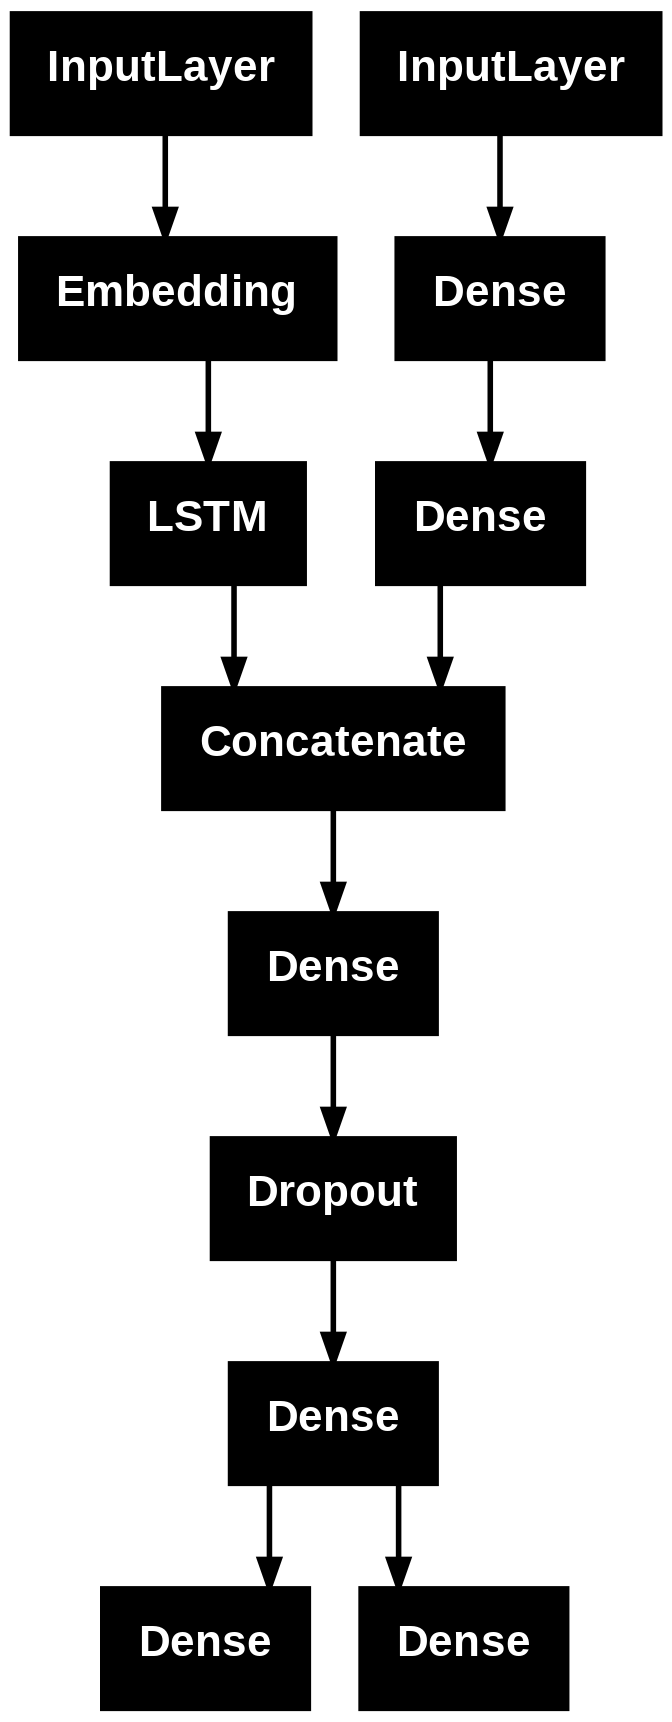

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)



#  **TARGET**


In [ ]:
data

,Review_Score,Review_Processed,season_Fall,season_Spring,season_Summer,season_Winter,hotel_pop_High,hotel_pop_Low,hotel_pop_Medium-High,hotel_pop_Medium-Low,...,continent_Europe,continent_North America,continent_Middle East,continent_Asia,continent_Oceania,continent_Africa,continent_South America,continent_Other,continent_Central America,Review_Type_Binary_Encoded
88526,6.7,expensive room rate that didn t include parkin...,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
42019,5.8,bedroom basement no windows very small room ne...,False,False,True,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
80574,6.3,room ready makeover location,True,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
27131,5.8,firstly lady check desk was quite unfriendly s...,False,False,False,True,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
63857,3.3,not being able park my vehicle due staff filli...,False,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11403,7.5,cleanliness room temperature location facilities,False,True,False,False,False,False,True,False,...,1,0,0,0,0,0,0,0,0,1
18169,8.8,cost parking location,True,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,1
15180,10.0,staff was very helpful,True,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
24929,10.0,tout home away from home,True,False,False,False,False,True,False,False,...,1,0,0,0,0,0,0,0,0,1


I will rename my classification / regression targets, that I already encoded for clearer naming when modeling, ensuring correct data types and verifying target distributions before training for both my classification and regression target.

In [ ]:
# Classification target (Good/Bad review)
classification_target = (data['Review_Type_Binary_Encoded']).astype(np.int32)
print(f"Classification target shape: {classification_target.shape}")
print(f"Classification target type: {classification_target.dtype}")
print(f"Class distribution: {np.bincount(classification_target)}")



Classification target shape: (13772,)
Classification target type: int32
Class distribution: [6888 6884]


In [ ]:
regression_target = data['Review_Score'].values.astype(np.float32)
print(f"Regression target shape: {regression_target.shape}")
print(f"Regression target type: {regression_target.dtype}")
print(f"Score range: [{regression_target.min():.1f}, {regression_target.max():.1f}]")


Regression target shape: (13772,)
Regression target type: float32
Score range: [2.5, 10.0]


## **LOSS FUNCTION**

I am now putting the loss functions and metrics for measuring how well the model is performing.

In the exam, I said I would have used:
- binary crossentropy for my classification sigmoid
- MSE for the regression

As metrics:
- accuracy for the classification part, since from exam data we knew we didn't have particularly unbalanced classes
- MAE for the regression

In [ ]:
loss_dict = {
    "classification_output": 'binary_crossentropy',  # For sigmoid output
    "regression_output": 'mse'                       # For linear output
}



## **METRICS CONFIGURATION**

In [ ]:
metric_dict = {
    "classification_output": 'accuracy',
    "regression_output": 'mae'
}


## **LOSS WEIGHTING**

In my exam, I wrote that, since we had two losses, the best approach was to do the weighted sum of the two.

In the exam, I wrote the formula "Total_loss = λ1 * MSE + λ2 * binary cross entropy".

I will put them with equal weights (1.0 each) initially, which can be tuned during training if one task dominates the other.

In [ ]:
loss_weights = {
    "classification_output": 1.0,  # λ2 for binary cross entropy
    "regression_output": 1.0       # λ1 for MSE
}

## **COMPILING THE MODEL**

prepares the training data in dictionary format for the multi-input, multi-output model

Implements train/test split to separate the data into training and test data, in order to measure the generalization capability.

I will use 80/20 as it is standard.


In [ ]:
# Split the data (80/20 as standard)
# Use stratify for balanced classification split
X_train_text, X_test_text, y_train_class, y_test_class = train_test_split(
    text_input, classification_target,
    test_size=0.2,
    random_state=42,
    stratify=classification_target  # Ensure balanced split
)

X_train_cat, X_test_cat, y_train_reg, y_test_reg = train_test_split(
    categorical_input, regression_target,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"Train class distribution: {np.bincount(y_train_class)}")
print(f"Test class distribution: {np.bincount(y_test_class)}")

Training samples: 11017
Test samples: 2755
Train class distribution: [5510 5507]
Test class distribution: [1378 1377]


This cell **organizes the split data into dictionary format** for the multi-input, multi-output model:

**Training data dictionaries:**
- **X_train**: Maps input names to training features (text sequences + categorical features)
- **y_train**: Maps output names to training targets (binary labels + continuous scores)

**Test data dictionaries:**
- **X_test/y_test**: Same structure for evaluation data

**Purpose**: Converts the individual arrays from train_test_split into the dictionary format required by Keras Functional API, matching my model's input/output layer names for proper data flow during training and evaluation.

In [ ]:
X_train = {
    'text_input': X_train_text,
    'categorical_input': X_train_cat
}

X_test = {
    'text_input': X_test_text,
    'categorical_input': X_test_cat
}

y_train = {
    'classification_output': y_train_class,
    'regression_output': y_train_reg
}

y_test = {
    'classification_output': y_test_class,
    'regression_output': y_test_reg
}


Defines the hyperparameter search space based on my exam answer.

**Parameters to optimize:**

- Learning rates: Tests different optimization speeds
- Batch sizes: Tests different mini-batch sizes for gradient updates
- Dropout rates: Tests different regularization strengths

**Purpose:**

Sets up the parameter ranges for random search hyperparameter optimization, focusing on the easily testable parameters I mentioned in my exam answer about using grid search/random search for the best hyperparameters.

In [ ]:
# Hyperparameters to test (from  my exam answer)
test_params = {
    'learning_rates': [0.001, 0.0005, 0.002],     # Learning rate
    'batch_sizes': [32, 64],                      # Batch size
    'dropout_rates': [0.1, 0.2],                 # Dropout
}

print("Parameters to test:")
for param, values in test_params.items():
    print(f"  {param}: {values}")

Parameters to test:
  learning_rates: [0.001, 0.0005, 0.002]
  batch_sizes: [32, 64]
  dropout_rates: [0.1, 0.2]


As a first thing, I will start with standard hyperparameters before optimization, since this establishes baseline performance before hyperparameter search.

In [ ]:
# Starting with standard hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 15
DROPOUT_RATE = 0.2


# Recompile model with specific hyperparameters

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=loss_dict,
    loss_weights=loss_weights,
    metrics=metric_dict
)

I will use early stopping to prevent overfitting and find optimal training point:

- Monitor validation loss for improvement
- Stop if no improvement for 5 epochs (patience)
- Restore best weights from training history

This establishes baseline performance before hyperparameter optimization.

In [ ]:
# Add callbacks

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("\n Starting baseline training...")

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,  # 80% train, 20% validation
    callbacks=[early_stopping],
    verbose=1
)

print("Baseline training complete!")



 Starting baseline training...
Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - classification_output_accuracy: 0.4967 - classification_output_loss: 0.7221 - loss: 14.2823 - regression_output_loss: 13.5601 - regression_output_mae: 2.8626 - val_classification_output_accuracy: 0.4982 - val_classification_output_loss: 0.6939 - val_loss: 5.0620 - val_regression_output_loss: 4.3688 - val_regression_output_mae: 1.7757
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - classification_output_accuracy: 0.5006 - classification_output_loss: 0.7221 - loss: 5.7542 - regression_output_loss: 5.0321 - regression_output_mae: 1.8904 - val_classification_output_accuracy: 0.5054 - val_classification_output_loss: 0.6963 - val_loss: 5.5830 - val_regression_output_loss: 4.8864 - val_regression_output_mae: 1.8305
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - classification_output_accuracy: 0.5114 - classification_output_loss: 0.7051 - loss: 5.3445 - regression_output_loss: 4.6393 - regre

## **EVALUATION ON TEST DATA**

Clearly we have separated data into training and test data, measuring then the the generalization capabilities of the model on unseen data.

In [ ]:
# Evaluate on test set (unseen data)
test_results = model.evaluate(X_test, y_test, verbose=0)

print("BASELINE TEST RESULTS:")
for i, metric_name in enumerate(model.metrics_names):
    print(f"  {metric_name}: {test_results[i]:.4f}")

# Extract key metrics
baseline_acc = test_results[3]  # classification accuracy
baseline_mae = test_results[4]  # regression MAE
baseline_loss = test_results[0] # total loss

print(f"\nBASELINE PERFORMANCE SUMMARY:")
print(f"  Test Accuracy: {baseline_acc:.4f}")
print(f"  Test MAE: {baseline_mae:.4f}")
print(f"  Test Loss: {baseline_loss:.4f}")

BASELINE TEST RESULTS:
  loss: 4.9636
  compile_metrics: 0.6931
  classification_output_loss: 4.2494
  regression_output_loss: 0.4980

BASELINE PERFORMANCE SUMMARY:
  Test Accuracy: 0.4980
  Test MAE: 1.7564
  Test Loss: 4.9636


okay, now that we have a baseline model we can go into the final part of the exam, where I said I would have used Cross Validation + Random Search or Grid Search for the search of the best hyper parameters

## **HYPERPARAMETER OPTIMIZATION: RANDOM SEARCH / GRID SEARCH**

Following exam answer: "The choice of hyperparameters could be done by using Grid Search or Random Search for looking for the best hyperparameters."

This implements random search to optimize the hyperparameters I mentioned in my exam:

- Learning rate
- batch size
- dropout rate
- number of neurons (LSTM units)


**Process:**
1. Define parameter ranges based on exam answer
2. Sample random combinations (5 trials for efficiency)
3. Train each configuration with validation split (cross-validation approach)
4. Select best parameters based on validation loss
5. Retrain final model with optimal hyperparameters
6. Evaluate on test set and compare with baseline performance

This addresses Point 5b from my exam about optimizing hyperparameters and Point 6 about assessing generalization capabilities on unseen data, through cross-validation by holding out part of the dataset.

I will do Random Search and not use cross-validation since it takes less time than GridSearch.

In [ ]:
print("\n" + "="*60)
print("RANDOM SEARCH FOR HYPERPARAMETERS")
print("="*60)

# Parameter ranges
param_ranges = {
    'learning_rate': [0.001, 0.0005, 0.002, 0.005],  # Learning rate
    'batch_size': [32, 64, 128],                     # Batch size
    'dropout_rate': [0.1, 0.2, 0.3],                # Dropout
    'lstm_units': [32, 64, 128]                     # Number of neurons
}

print("Testing parameters:")
for param, values in param_ranges.items():
    print(f"  {param}: {values}")

def create_model_with_params(lr, dropout, lstm_units):

    # Input layers
    text_input_layer = Input(shape=text_feature_shape, dtype='int32', name="text_input")
    categorical_input_layer = Input(shape=categorical_feature_shape, dtype='float32', name="categorical_input")

    # Text branch
    x1 = Embedding(input_dim=tot_uniq_words,
                   output_dim=128,  # Same as my current model
                   input_length=MAX_SEQUENCE_LENGTH,
                   embeddings_initializer='glorot_uniform',  # Better than default
                   name="embedding")(text_input_layer)

    x1 = LSTM(units=lstm_units,  # Variable LSTM units
              activation='tanh',  # As per exam
              name="lstm")(x1)

    # Categorical branch
    x2 = Dense(32, activation='relu', name="categorical_dense1")(categorical_input_layer)
    x2 = Dense(16, activation='relu', name="categorical_dense2")(x2)

    # Merge
    merged = Concatenate(name="concatenate")([x1, x2])
    merged = Dense(32, activation='relu', name="merged_dense1")(merged)
    merged = Dropout(dropout, name="dropout")(merged)  # Variable dropout
    merged = Dense(16, activation='relu', name="merged_dense2")(merged)

    # Outputs
    classification_output = Dense(1, activation='sigmoid', name="classification_output")(merged)
    regression_output = Dense(1, activation=None, name="regression_output")(merged)

    # Create model
    model = Model(inputs=[text_input_layer, categorical_input_layer],
                  outputs=[classification_output, regression_output])

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),  # Variable learning rate
        loss=loss_dict,
        loss_weights=loss_weights,
        metrics=metric_dict
    )

    return model

# Random search execution
print(f"\n=== STARTING RANDOM SEARCH ===")
n_trials = 5  # Quick search
best_score = float('inf')
best_params = None
best_model = None

random.seed(42)  # Reproducibility

for trial in range(n_trials):
    # Sample random parameters
    params = {k: random.choice(v) for k, v in param_ranges.items()}
    print(f"\nTrial {trial+1}/{n_trials}: {params}")

    # Create model with random parameters
    trial_model = create_model_with_params(
        lr=params['learning_rate'],
        dropout=params['dropout_rate'],
        lstm_units=params['lstm_units']
    )

    # Train with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    history = trial_model.fit(
        x=X_train, y=y_train,
        batch_size=params['batch_size'],
        epochs=10,  # Reduced for speed
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0  # Silent training
    )

    # Check performance
    val_loss = min(history.history['val_loss'])
    val_acc = max(history.history['val_classification_output_accuracy'])
    val_mae = min(history.history['val_regression_output_mae'])

    print(f"Results: Loss={val_loss:.4f}, Acc={val_acc:.4f}, MAE={val_mae:.4f}")

    # Track best
    if val_loss < best_score:
        best_score = val_loss
        best_params = params.copy()
        best_model = trial_model
        print("NEW BEST PARAMETERS!")

print(f"\n" + "="*50)
print("RANDOM SEARCH RESULTS")
print("="*50)
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score:.4f}")

# Train final model with best parameters
print(f"\n=== FINAL TRAINING WITH BEST PARAMETERS ===")
final_model = create_model_with_params(
    lr=best_params['learning_rate'],
    dropout=best_params['dropout_rate'],
    lstm_units=best_params['lstm_units']
)

final_history = final_model.fit(
    x=X_train, y=y_train,
    batch_size=best_params['batch_size'],
    epochs=20,  # Full training
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Final evaluation
final_results = final_model.evaluate(X_test, y_test, verbose=0)

print(f"\n FINAL OPTIMIZED RESULTS:")
for i, metric_name in enumerate(final_model.metrics_names):
    print(f"  {metric_name}: {final_results[i]:.4f}")




RANDOM SEARCH FOR HYPERPARAMETERS
Testing parameters:
  learning_rate: [0.001, 0.0005, 0.002, 0.005]
  batch_size: [32, 64, 128]
  dropout_rate: [0.1, 0.2, 0.3]
  lstm_units: [32, 64, 128]

=== STARTING RANDOM SEARCH ===

Trial 1/5: {'learning_rate': 0.001, 'batch_size': 32, 'dropout_rate': 0.3, 'lstm_units': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Results: Loss=5.1986, Acc=0.5059, MAE=1.7813
NEW BEST PARAMETERS!

Trial 2/5: {'learning_rate': 0.005, 'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 32}
Results: Loss=5.1738, Acc=0.5054, MAE=1.7839
NEW BEST PARAMETERS!

Trial 3/5: {'learning_rate': 0.005, 'batch_size': 32, 'dropout_rate': 0.2, 'lstm_units': 128}
Results: Loss=5.4385, Acc=0.5054, MAE=1.8105

Trial 4/5: {'learning_rate': 0.0005, 'batch_size': 32, 'dropout_rate': 0.2, 'lstm_units': 32}
Results: Loss=5.1897, Acc=0.5064, MAE=1.7852

Trial 5/5: {'learning_rate': 0.005, 'batch_size': 128, 'dropout_rate': 0.1, 'lstm_units': 64}
Results: Loss=4.9522, Acc=0.5091, MAE=1.7729
NEW BEST PARAMETERS!

RANDOM SEARCH RESULTS
Best parameters: {'learning_rate': 0.005, 'batch_size': 128, 'dropout_rate': 0.1, 'lstm_units': 64}
Best validation loss: 4.9522

=== FINAL TRAINING WITH BEST PARAMETERS ===
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - classification_output_accuracy: 0.5009 - classification_output_loss: 0.8840 - loss:

- cross validation (5 folds)

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

def create_model_cv():
    # Input layers - using existing shapes
    text_feature_shape = (MAX_SEQUENCE_LENGTH,)
    categorical_feature_shape = (len(categorical_columns),)

    text_input_layer = Input(shape=text_feature_shape, dtype='int32', name="text_input")
    categorical_input_layer = Input(shape=categorical_feature_shape, dtype='float32', name="categorical_input")

    # Text processing branch
    x1 = Embedding(input_dim=tot_uniq_words,
                   output_dim=128,
                   input_length=MAX_SEQUENCE_LENGTH,
                   name="embedding")(text_input_layer)
    x1 = LSTM(units=64, activation='tanh', name="lstm")(x1)

    # Categorical processing branch
    x2 = Dense(32, activation='relu', name="categorical_dense1")(categorical_input_layer)
    x2 = Dense(16, activation='relu', name="categorical_dense2")(x2)

    # Merge branches
    merged = Concatenate(name="concatenate")([x1, x2])
    merged = Dense(32, activation='relu', name="merged_dense1")(merged)
    merged = Dropout(0.2, name="dropout")(merged)
    merged = Dense(16, activation='relu', name="merged_dense2")(merged)

    # Outputs
    classification_output = Dense(1, activation='sigmoid', name="classification_output")(merged)
    regression_output = Dense(1, activation=None, name="regression_output")(merged)

    # Create and compile model
    cv_model = Model(inputs=[text_input_layer, categorical_input_layer],
                     outputs=[classification_output, regression_output],
                     name='CV_Model')

    cv_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss_dict,
        loss_weights=loss_weights,
        metrics=metric_dict
    )

    return cv_model

print("\n" + "="*80)
print("STARTING 5-FOLD CROSS-VALIDATION")
print("="*80)

# Convert to numpy arrays if needed (handle both pandas Series and numpy arrays)
if hasattr(classification_target, 'values'):
    classification_target_array = classification_target.values
else:
    classification_target_array = classification_target

if hasattr(regression_target, 'values'):
    regression_target_array = regression_target.values
else:
    regression_target_array = regression_target





# Use stratified k-fold for balanced splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




# Store results
cv_results = []

fold = 0
for train_idx, val_idx in skf.split(text_input, classification_target_array):
    fold += 1
    print(f"\n--- FOLD {fold}/5 ---")

    # Split data for this fold
    X_train_text_cv = text_input[train_idx]
    X_val_text_cv = text_input[val_idx]
    X_train_cat_cv = categorical_input[train_idx]
    X_val_cat_cv = categorical_input[val_idx]

    y_train_class_cv = classification_target_array[train_idx]
    y_val_class_cv = classification_target_array[val_idx]
    y_train_reg_cv = regression_target_array[train_idx]
    y_val_reg_cv = regression_target_array[val_idx]

    print(f"Train: {len(X_train_text_cv)}, Val: {len(X_val_text_cv)}")

    # Prepare data dictionaries
    X_train_cv = {
        'text_input': X_train_text_cv,
        'categorical_input': X_train_cat_cv
    }

    X_val_cv = {
        'text_input': X_val_text_cv,
        'categorical_input': X_val_cat_cv
    }

    y_train_cv = {
        'classification_output': y_train_class_cv,
        'regression_output': y_train_reg_cv
    }

    y_val_cv = {
        'classification_output': y_val_class_cv,
        'regression_output': y_val_reg_cv
    }

    # Create fresh model
    cv_model = create_model_cv()

    # Early stopping for CV
    early_stopping_cv = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=0
    )

    # Train model
    history_cv = cv_model.fit(
        x=X_train_cv,
        y=y_train_cv,
        validation_data=(X_val_cv, y_val_cv),
        batch_size=32,
        epochs=15,
        callbacks=[early_stopping_cv],
        verbose=0
    )

    # Get final epoch results
    final_epoch = len(history_cv.history['loss']) - 1

    fold_result = {
        'fold': fold,
        'val_loss': history_cv.history['val_loss'][final_epoch],
        'val_accuracy': history_cv.history['val_classification_output_accuracy'][final_epoch],
        'val_mae': history_cv.history['val_regression_output_mae'][final_epoch],
        'train_loss': history_cv.history['loss'][final_epoch],
        'train_accuracy': history_cv.history['classification_output_accuracy'][final_epoch],
        'train_mae': history_cv.history['regression_output_mae'][final_epoch]
    }

    cv_results.append(fold_result)

    print(f"Val Loss: {fold_result['val_loss']:.4f}")
    print(f"Val Accuracy: {fold_result['val_accuracy']:.4f}")
    print(f"Val MAE: {fold_result['val_mae']:.4f}")

# Convert to DataFrame and analyze results
cv_df = pd.DataFrame(cv_results)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*80)

print("\nVALIDATION METRICS:")
print("-" * 50)
print(f"Validation Loss:     {cv_df['val_loss'].mean():.4f} ± {cv_df['val_loss'].std():.4f}")
print(f"Validation Accuracy: {cv_df['val_accuracy'].mean():.4f} ± {cv_df['val_accuracy'].std():.4f}")
print(f"Validation MAE:      {cv_df['val_mae'].mean():.4f} ± {cv_df['val_mae'].std():.4f}")

print("\nTRAINING METRICS:")
print("-" * 50)
print(f"Training Loss:       {cv_df['train_loss'].mean():.4f} ± {cv_df['train_loss'].std():.4f}")
print(f"Training Accuracy:   {cv_df['train_accuracy'].mean():.4f} ± {cv_df['train_accuracy'].std():.4f}")
print(f"Training MAE:        {cv_df['train_mae'].mean():.4f} ± {cv_df['train_mae'].std():.4f}")



print(f"\n=== COMPARISON WITH BASELINE ===")
print(f"CV Validation Accuracy:  {cv_df['val_accuracy'].mean():.4f} ± {cv_df['val_accuracy'].std():.4f}")
print(f"CV Validation MAE:       {cv_df['val_mae'].mean():.4f} ± {cv_df['val_mae'].std():.4f}")
print(f"CV Validation Loss:      {cv_df['val_loss'].mean():.4f} ± {cv_df['val_loss'].std():.4f}")

print(f"\nBaseline Test Accuracy:  {baseline_acc:.4f}")
print(f"Baseline Test MAE:       {baseline_mae:.4f}")
print(f"Baseline Test Loss:      {baseline_loss:.4f}")

# Check consistency
acc_diff = abs(cv_df['val_accuracy'].mean() - baseline_acc)
mae_diff = abs(cv_df['val_mae'].mean() - baseline_mae)

print(f"\nDifference Analysis:")
print(f"Accuracy difference:     {acc_diff:.4f}")
print(f"MAE difference:          {mae_diff:.4f}")


STARTING 5-FOLD CROSS-VALIDATION

--- FOLD 1/5 ---
Train: 11017, Val: 2755


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Val Loss: 5.2988
Val Accuracy: 0.5002
Val MAE: 1.7845

--- FOLD 2/5 ---
Train: 11017, Val: 2755
Val Loss: 5.6513
Val Accuracy: 0.4998
Val MAE: 1.8440

--- FOLD 3/5 ---
Train: 11018, Val: 2754
Val Loss: 6.1683
Val Accuracy: 0.5033
Val MAE: 1.9288

--- FOLD 4/5 ---
Train: 11018, Val: 2754
Val Loss: 5.4820
Val Accuracy: 0.5207
Val MAE: 1.8103

--- FOLD 5/5 ---
Train: 11018, Val: 2754
